# Computer Vision - Challenges with Camera

We will calibrate the camera, undistort an image, and apply a perspective transform. Perform undistorted and perspective transform.

Learned how cameras work, the distortions they cause, and how to correct for that distortion. Learn about perspective transformation - a great method to help one see a view from a different angle than the original image.

In [7]:
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/wide_dist_pickle.p
!wget https://raw.githubusercontent.com/udacity/CarND-Camera-Calibration/master/calibration_wide/test_image.jpg
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/test_image2.png
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/sobel_example/signs_vehicles_xygrad.png
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/color_spaces/colorspace_test_images.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/luv_example/bridge_shadow.jpg
!wget https://raw.githubusercontent.com/prathmesh-dali/Project-4/master/warped-example.jpg
!git clone https://github.com/udacity/CarND-Camera-Calibration.git

--2020-03-28 13:14:01--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/wide_dist_pickle.p
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16048 (16K) [binary/octet-stream]
Saving to: ‘wide_dist_pickle.p’

wide_dist_pickle.p  100%[===================>]  15.67K  --.-KB/s    in 0s      

2020-03-28 13:14:02 (225 MB/s) - ‘wide_dist_pickle.p’ saved [16048/16048]

--2020-03-28 13:14:03--  https://raw.githubusercontent.com/udacity/CarND-Camera-Calibration/master/calibration_wide/test_image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting

In [8]:
!unzip colorspace_test_images.zip  -d colorspace_test_images

Archive:  colorspace_test_images.zip
  inflating: colorspace_test_images/test1.jpg  
   creating: colorspace_test_images/__MACOSX/
  inflating: colorspace_test_images/__MACOSX/._test1.jpg  
  inflating: colorspace_test_images/test4.jpg  
  inflating: colorspace_test_images/__MACOSX/._test4.jpg  
  inflating: colorspace_test_images/test6.jpg  
  inflating: colorspace_test_images/__MACOSX/._test6.jpg  


In [0]:
# Import libraries
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import os

## Correcting for Distortion

In [0]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

In [0]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [0]:
# Make a list of calibration images
images = glob.glob('CarND-Camera-Calibration/calibration_wide/GO*.jpg')

Run to produce objpoints and imgpoints needed for camera calibration.

In [0]:
# Create directory `calibration_wide` to store wide_dist_pickle.p
if not os.path.exists('calibration_wide'):
   os.mkdir('calibration_wide')

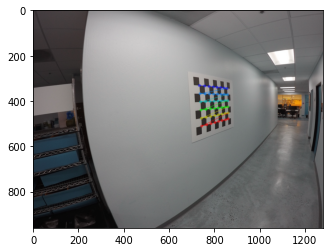

In [14]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)     # object points to be stored
        imgpoints.append(corners)  # image points to be stored

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        plt.imshow(img)
        
        cv2.waitKey(500)

# Destroy all windows
cv2.destroyAllWindows()

Text(0.5, 1.0, 'Undistorted Image')

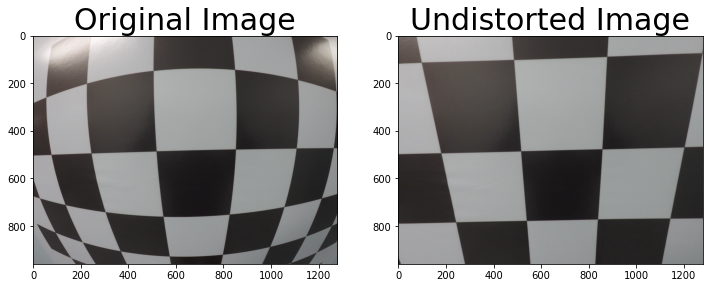

In [15]:
# Test undistortion on an image
img = cv2.imread('CarND-Camera-Calibration/calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints,
                                                   img_size, 
                                                   None,
                                                   None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg', dst)
#cv2.imwrite('CarND-Camera-Calibration/calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration_wide/wide_dist_pickle.p", "wb" ))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

**Camera Calibration**

Calculate the camera matrix and distortion coefficients.

In [0]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load(open("wide_dist_pickle.p", "rb" ))
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

In [0]:
# Read in an image
#img = cv2.imread('test_image.jpg')
img = cv2.imread('CarND-Camera-Calibration/calibration_wide/test_image.jpg')

In [0]:
# Define a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    
    # Converting an image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Finding chessboard corners (for an 8x6 board)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    
    # Drawing detected corners on an image
    img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    
    # Camera calibration, given object points, image points, 
    # and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints,
                                                       gray.shape[::-1],# image size
                                                       None, None)
    
    # Undistorting a test image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    undist = np.copy(undist)
 
    return undist

In [0]:
# Run to calibrate, calculate distortion coefficients, and test undistortion on an image
undistorted = cal_undistort(img, objpoints, imgpoints)

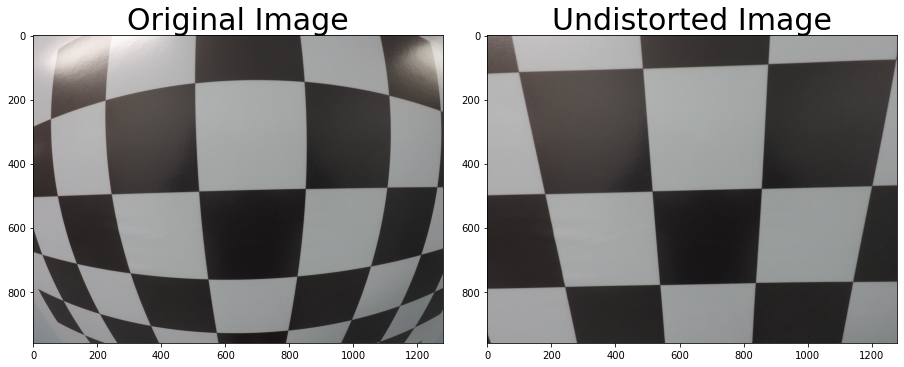

In [20]:
# Visualize distored and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane Curvature 
Self-driving cars need to be told the correct steering angle to turn, left or right. We can calculate this angle if we know a few things about the speed and dynamics of the car and how much the lane is curving.

One way to calculate the curvature of a lane line, is to fit a 2nd degree polynomial to that line, and from this we can easily extract useful information.

For a lane line that is close to vertical, we can fit a line using this formula: f(y) = Ay^2 + By + C, where A, B, and C are coefficients.

A gives us the curvature of the lane line, B gives us the heading or direction that the line is pointing, and C gives us the position of the line based on how far away it is from the very left of an image (y = 0).

**Perspective Transform**

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform we’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.


Select source points by detecting four source points algorithmatically in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels.

**Camera calibration process**

The purpose is to compute the transform between 3D object points in the world and 2D image points.

**Distortion correction process**
The purpose is to ensure that the geometrical shape of objects is represented consistently,  no matter where they appear in an image.

**Perspective transform process**

The purpose is to transform an image such that we care effectively viewing objecxts from a different angle or direction.


In [0]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays we calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

**Transform a Stop sign using perspective tranform**

In [0]:
# Read in an image
img = cv2.imread('test_image2.png')
#img = cv2.imread('CarND-Camera-Calibration/calibration_wide/test_image2.png') # doesn't work why??

nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

In [0]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in the image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # 2) Convert to grayscale
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # 3) Find the chessboard corners (for an 8x6 board)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # 4) If corners found: 
    if ret == True:
      # 4.a) draw corners
      # If we found corners, draw detected corners on an image! 
      cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
      # 4.b) define 4 source points src = np.float32([[,],[,],[,],[,]])
      # Note: we could pick any four of the detected corners 
      # as long as those four corners define a rectangle
      # One especially smart way to do this would be to use four well-chosen
      # corners that were automatically detected during the undistortion steps
      # We recommend using the automatic detection of corners in our code
      
      # Choose offset from image corners to plot detected corners
      # This should be chosen to present the result at the proper aspect ratio
      # My choice of 100 pixels is not exact, but close enough for our purpose here
      offset = 100 # offset for dst points
      # Grab the image shape
      img_size = (gray.shape[1], gray.shape[0])
      # For source coordinate points let's grabbing the outer four detected corners
      src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]]) # 4 points

      # 4.c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
      # For destination points, le's arbitrarily choosing some target coordinate 
      # points to be a nice fit for displaying our warped result 
      # again, not exact, but close enough for our purposes
      dst = np.float32([[offset, offset], 
                        [img_size[0]-offset, offset], 
                        [img_size[0]-offset, img_size[1]-offset],
                        [offset, img_size[1]-offset]])
      
      # 4.d) use cv2.getPerspectiveTransform() to get M, the transform matrix
      # Compute the perspective transform, M, given source and destination points
      # Given src and dst points, calculate the perspective transform matrix
      M = cv2.getPerspectiveTransform(src, dst)

      # Compute the inverse perspective transform
      #Minv = cv2.getPerspectiveTransform(dst, src)

      # 4.e) use cv2.warpPerspective() to warp our image to a top-down view
      # Warp an image using the perspective transform, M
      # Warp the image using OpenCV warpPerspective()
      warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M

In [0]:
# Run undistort and transformation
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

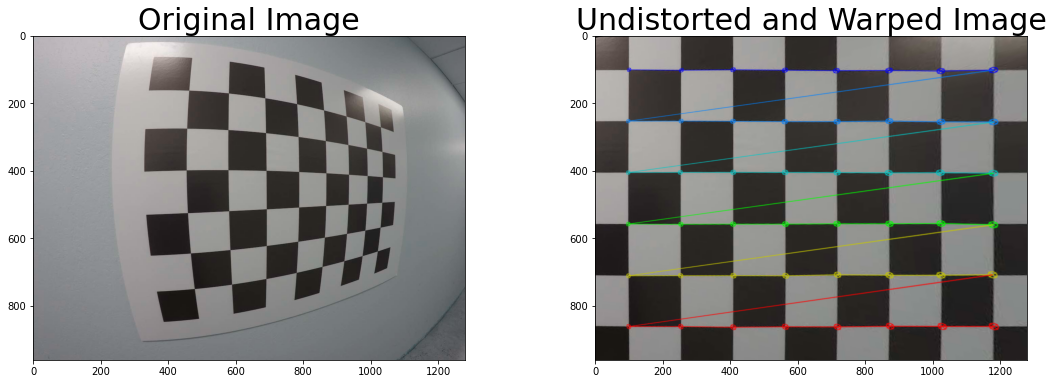

In [28]:
# Visualize undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Applying Sobel Operator
Sobel Operator takes the gradient in x or y and set thresholds to identify pixels within a certain gradient range. For example, pixels have a value of 1 or 0 based on the strength of the `x` gradient.

In [0]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold
def abs_sobel_thresh(img, orient='x', thresh=(20, 100), sobel_kernel=3):
  thresh_min, thresh_max = thresh
  ## Apply the following steps to img

  # 1) Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 2) Take the derivative in x or y given orient = 'x' or 'y'
  # Apply x or y gradient with the OpenCV Sobel() function
  # and take the absolute value
  if orient == 'x': # Apply cv2.Sobel()
    # Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  if orient == 'y': # Apply cv2.Sobel()
    # Calculate the derivative in the yy direction (the 0, 1 at the end denotes yy direction)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  # 3) Take the absolute value of the derivative or gradient from cv2.Sobel()
  abs_sobel = np.absolute(sobel)

  # 4) Re-Scale back to 8-bit (0 - 255) integer then convert to type = np.uint8
  #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
  scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8) 

  # Create a binary_output copy and apply the threshold
  binary_output = np.zeros_like(scaled_sobel)

  # 5) Create a mask of 1's where the scaled gradient magnitude 
  # is > thresh_min and < thresh_max
  # Apply lower and upper thresholds
  # Here we're using inclusive (>=, <=) thresholds, but exclusive is ok too
  # Create a binary threshold to select pixels based on gradient strength
  binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

  # 6) Return this mask as the binary_output image result
  return binary_output

In [0]:
# Read in an image and grayscale it
image = mpimg.imread('signs_vehicles_xygrad.png')

In [0]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))

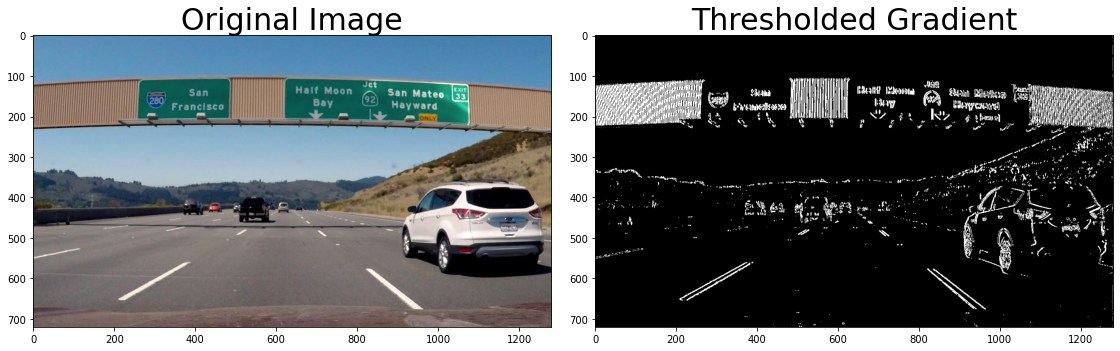

In [32]:
# Plot the result of Sobel image gradients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Magnitude of the Gradient

In [0]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
  ## Apply the following steps to img

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # Take both Sobel x and y gradients separately
  sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

  # Calculate the magnitude of the gradient
  gradmag = np.sqrt(sobelx**2 + sobely**2)

  #  Rescale to 8-bit (0 - 255) and convert to type = np.uint8
  scale_factor = np.max(gradmag)/255 
  gradmag = (gradmag/scale_factor).astype(np.uint8) 

  # Create a binary mask of 1's where mag thresholds are met, zeros otherwise
  binary_output = np.zeros_like(gradmag)
  binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

  # Return this mask as a binary_output image
  return binary_output

In [0]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

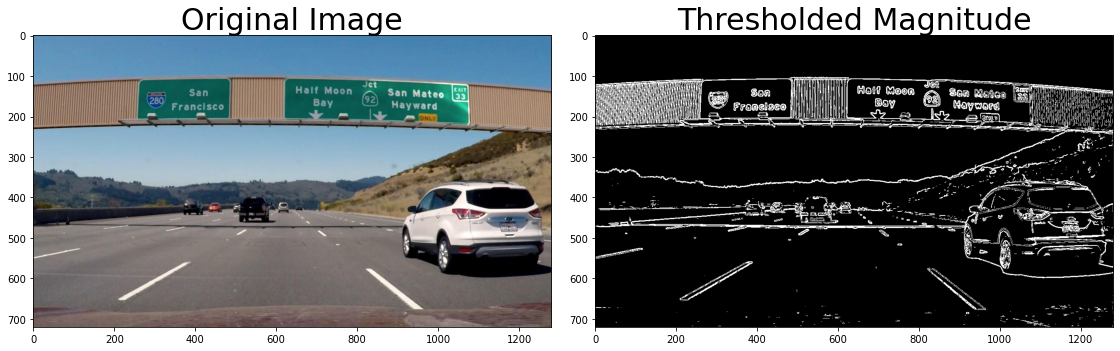

In [35]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the Gradient

In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient. The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient.

In [0]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
  ## Apply the following steps to img
  # 1) Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 2) Take the gradient in x and y separately
  sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
  # 3) Take the absolute value of the x and y gradients
  abs_sobelx = np.absolute(sobelx)
  abs_sobely = np.absolute(sobely)
    
  # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
  absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
  # 5) Create a binary mask where direction thresholds are met
  binary_output = np.zeros_like(absgraddir)
  binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
     
  # 6) Return this mask as a binary_output image
  binary_output = np.copy(binary_output) 
    
  return binary_output

In [0]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3)) #sobel_kernel=15

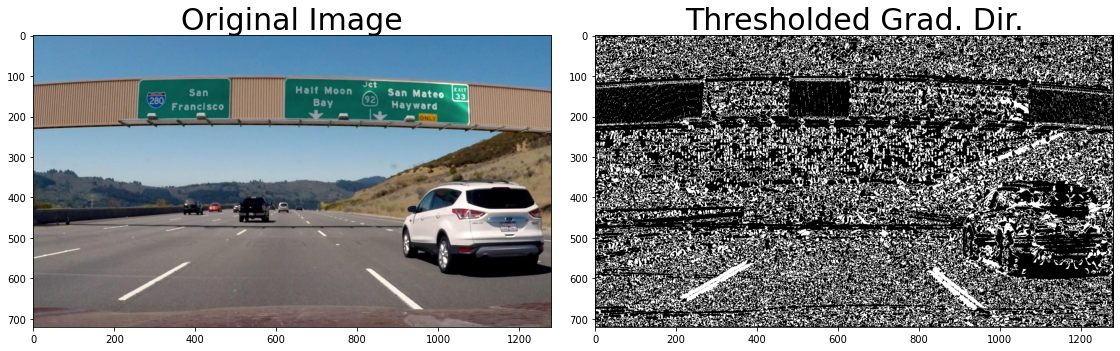

In [38]:
# Plot the result of Direction of the Gradient
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Thresholds

We can use various aspects of the gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how we can use thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines.

In [0]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

In [0]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))

mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) # thresh=(0, np.pi/2)

In [0]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

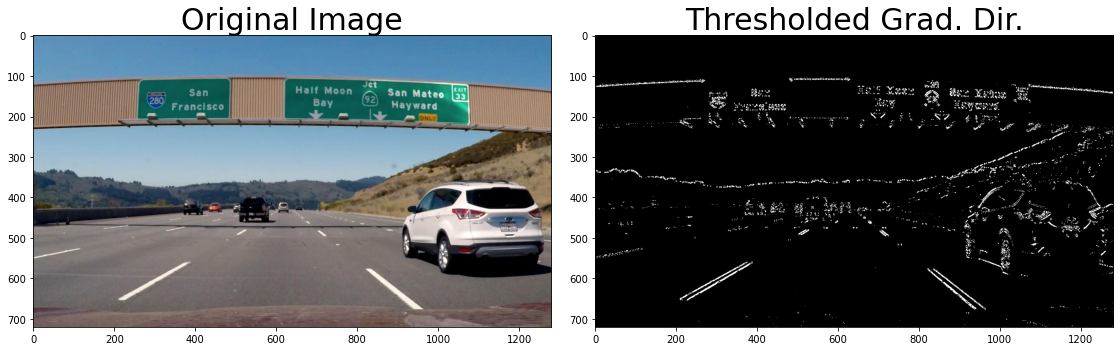

In [42]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## HLS and Color Thresholds

In [0]:
image = mpimg.imread('colorspace_test_images/test6.jpg')
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

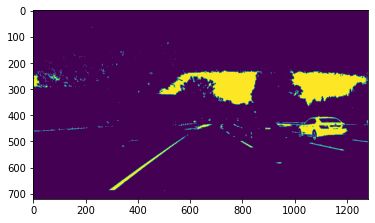

In [44]:
plt.imshow(binary)

In [0]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

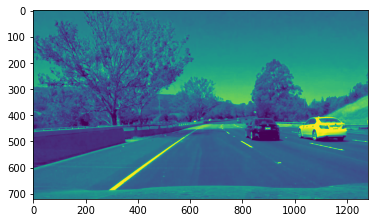

In [46]:
plt.imshow(R)

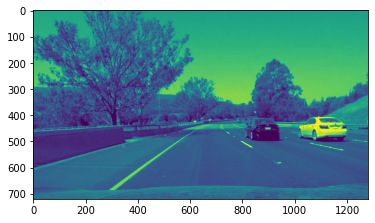

In [47]:
plt.imshow(G)

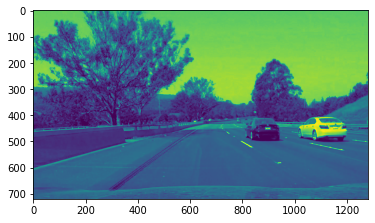

In [48]:
plt.imshow(B)

The R channel does a reasonable job of highlighting the lines, and we can apply a similar threshold to find lane-line pixels.

In [0]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

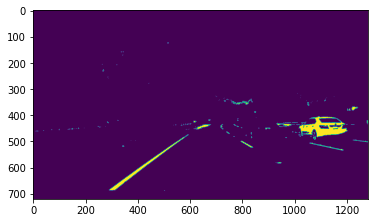

In [50]:
plt.imshow(binary)

 When we separate the H, L, and S channels we get the following result.

In [0]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

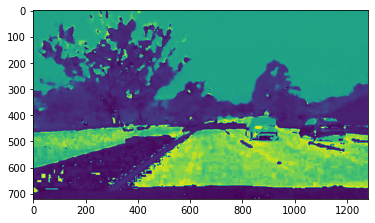

In [52]:
plt.imshow(H)

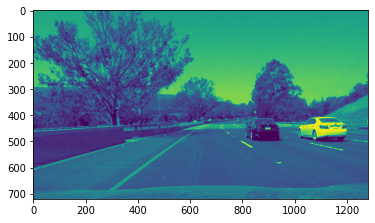

In [53]:
plt.imshow(L)

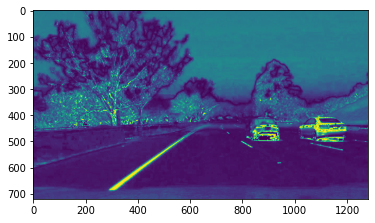

In [54]:
plt.imshow(S)

The S channel picks up the lines well, so let's try applying a threshold there.

In [0]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

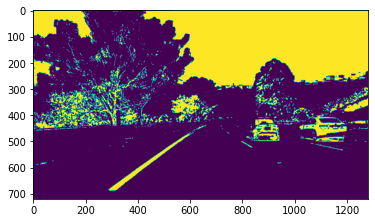

In [56]:
plt.imshow(binary)

We can also see that in the H channel, the lane lines appear dark, so we could try a low threshold there and obtain the following result.

In [0]:
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

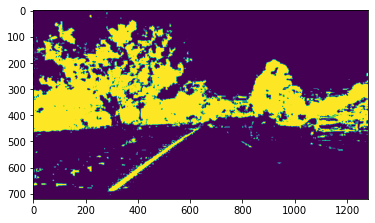

In [58]:
plt.imshow(binary)

From these examples, we can see that the S channel is probably our best bet. It's cleaner than the H channel result and a bit better than the R channel or simple grayscaling. But it's not clear that one method is far superior to the others.

In this example the S channel is preferable because it is more robust to changing conditions.

It's worth noting, however, that the R channel still does rather well on the white lines, perhaps even better than the S channel. As with gradients, it's worth considering how we might combine various color thresholds to make the most robust identification of the lines.

In [0]:
# TODO: Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    binary_output = np.copy(binary_output) # placeholder line
    return binary_output

In [0]:
# Optional TODO - tune the threshold to try to match the above image!    
hls_binary = hls_select(image, thresh=(90, 255)) # thresh=(0, 255)

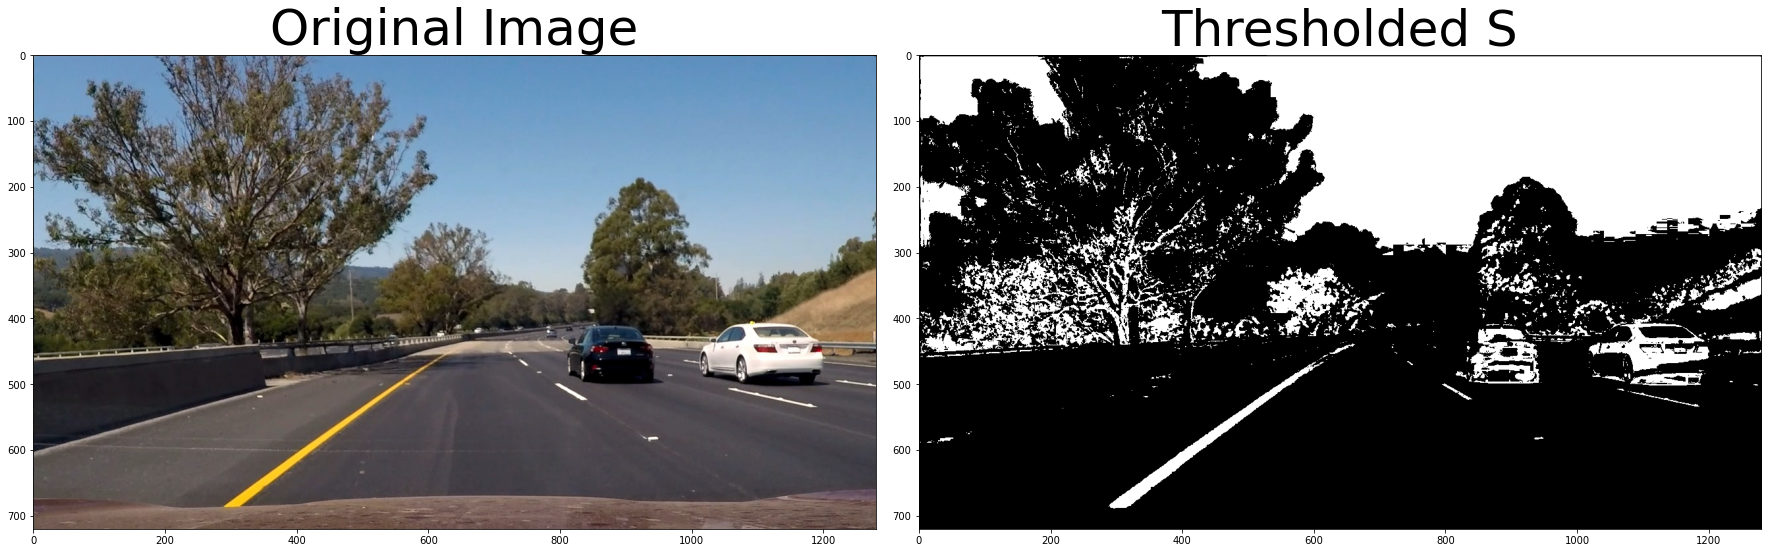

In [61]:
# Plot the result of HLS and Color Thresholds
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient

We now combine what you know about color and gradient thresholding to get the best of both worlds. 

In [0]:
# Combined color and gradient threshold for lane detection

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

In [0]:
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [0]:
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

In [0]:
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

In [0]:
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

In [0]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

In [0]:
# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

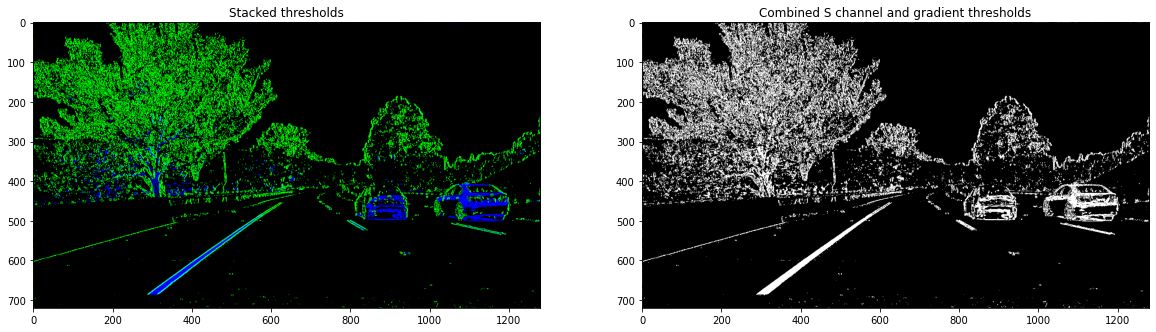

In [69]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

The final image color_binary is a combination of binary thresholding the S channel (HLS) and binary thresholding the result of applying the Sobel operator in the x direction on the original image. (Left) Stakced image: the green is the gradient threshold component and the blue is the color channel threshold component. (Right) black and white combined thresholded image - this one has combined both gradient and color threshold into one imnage.

Next we will explore this might include: the H channel, different threshold values for color and gradient binary images, and even a different color space, like HSV!

In [0]:
image = mpimg.imread('bridge_shadow.jpg')

In [0]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

In [0]:
result = pipeline(image)

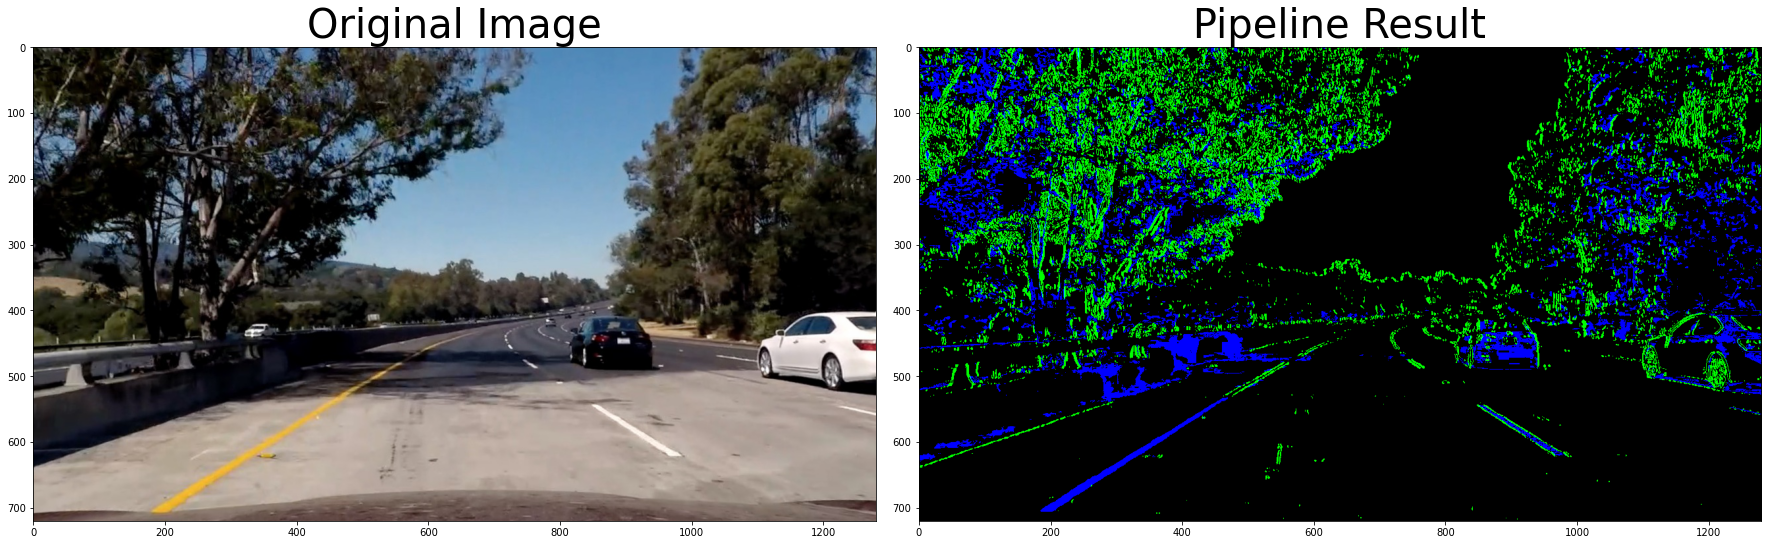

In [73]:
# Plot the result of Color and Gradient
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

- Camera Calibration - Camera calibration matrix and distortion coefficients
- Distortion Correction - Correct for image distortion
- Color & Gradient Threshold - Apply color and gradient threshold
- Perspective Transformation - Warp the image using perspective tranformation

* Detect lane lines
* Determine the lane curvature


## Locate the Lane Lines

We now have a thresholded warped image and you're ready to map out the lane lines!

**Line Finding Method: Peaks in a Histogram**

After applying calibration, thresholding, and a perspective transform to a road image, we should have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

In [0]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
out_img = mpimg.imread('warped-example.jpg')/255

In [0]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [0]:
# Create histogram of image binary activations
histogram = hist(out_img)

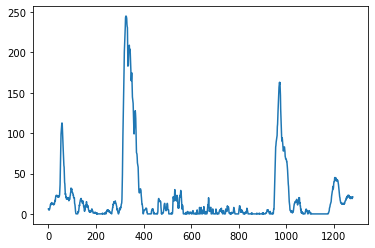

In [77]:
# Visualize the resulting histogram
plt.plot(histogram)

## Sliding Windows and Fit a Polynomial

We can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

**Fit a polynomial**

Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have a couple small steps to ready our pixels.

In [0]:
# Load our image
binary_warped = mpimg.imread('warped-example.jpg')

In [0]:
# Find lane pixels
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin    # default 0
        win_xleft_high = leftx_current + margin   # default 0
        win_xright_low = rightx_current - margin  # default 0
        win_xright_high = rightx_current + margin # default 0
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] #None
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0] #None
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix: # None
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) 
        if len(good_right_inds) > minpix: # None   
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)    # None
    right_fit = np.polyfit(righty, rightx, 2) # None

    #print('left_fit', left_fit)
    #print('right_fit', right_fit)

    # Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return out_img

left_fit [ 2.23090058e-04 -3.90812851e-01  4.78139852e+02]
right_fit [ 4.19709859e-04 -4.79568379e-01  1.11522544e+03]


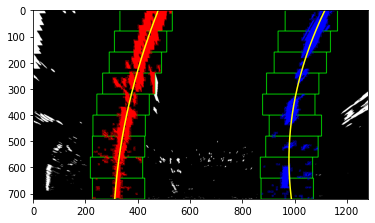

In [97]:
# Visualization the results of Locate the Lane Lines
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

## Finding the Lines: Search from Prior

Skip the sliding windows step once we've found the lines. We can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once we know where the lines are in one frame of video, we can do a highly targeted search for them in the next frame.

In [0]:
# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('warped-example.jpg')

In [0]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in our project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

In [0]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    #left_fitx = None
    #right_fitx = None
    # Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

In [0]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on our own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                     left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                     left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                     right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

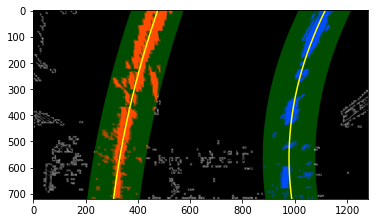

In [105]:
# Run image through the pipeline
# Note that in our project, we'll also want to feed in the previous fits
result = search_around_poly(binary_warped)
# View output results of finding lines search from prior
plt.imshow(result)

**Fitting on Large Curves**

One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If minpix is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in nwindows, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

## Measuring Curvature

have a thresholded image, where we've estimated which pixels belong to the left and right lane lines (shown in red and blue, respectively, above), and we've fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.

In [0]:
def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)

    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    return ploty, left_fit, right_fit

In [0]:
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    #left_curverad = 0  ## Implement the calculation of the left line here
    #right_curverad = 0  ## Implement the calculation of the right line here
    
    # Calculated the radius of curvature for our lane lines (reported pixel-space not the same as real world space)
    # using the radius of curvature formula based on the coefficient of the polynomial equation used in the fit
    left_curverad  = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5 / np.absolute(2*left_fit[0])
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5 / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

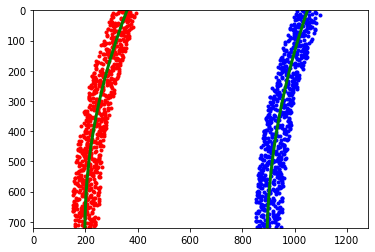

In [115]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

In [116]:
print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657204 1976.2967307714334


## From Pixels to Real-World

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

Let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!), and we'll say roughly 700 relevant pixels in the x-dimension (our example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700). Therefore, to convert from pixels to real-world meter measurements, we can use.

In [0]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Should we be using 'left_fit_cr' and 'right_fit_cr' bellkow instead??
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    return ploty, left_fit_cr, right_fit_cr

In [0]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    #left_curverad = 0  ## Implement the calculation of the left line here
    #right_curverad = 0  ## Implement the calculation of the right line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

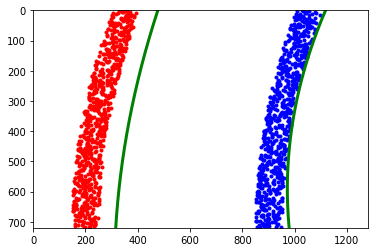

In [132]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

In [133]:
print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210938 m 648.157485143441 m
